In [1]:
#!pip install -q "flwr[simulation]" flwr-datasets

In [2]:
#!pip install medmnist

In [1]:

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms
from torch.utils.data import random_split


import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'retinamnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
info

{'python_class': 'RetinaMNIST',
 'description': 'The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/retinamnist.npz?download=1',
 'MD5': 'bd4c0672f1bba3e3a89f0e4e876791e4',
 'url_64': 'https://zenodo.org/records/10519652/files/retinamnist_64.npz?download=1',
 'MD5_64': 'afda852cc34dcda56f86ad2b2457dbcc',
 'url_128': 'https://zenodo.org/records/10519652/files/retinamnist_128.npz?download=1',
 'MD5_128': 'e48e916a24454daf90583d4e6efb1a18',
 'url_224': 'https://zenodo.org/records/10519652/files/retinamnist_224.npz?download=1',
 'MD5_224': 'eae7e3b6f3fcbda4ae613ebdcbe35348',
 'task': 

In [5]:
n_channels

3

In [6]:
n_classes

5

In [7]:
# Setup
BATCH_SIZE = 32
IMAGE_SIZE = 128
USE_AMP = True  # Mixed precision

TASK = "multi-label, binary-class"
DOWNLOAD = True

In [8]:
# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Data downloading (assuming the DataClass is already defined). The following commands download the dataset (~1.43GB).
train_dataset = DataClass(split='train', transform=data_transform, download=DOWNLOAD, size=IMAGE_SIZE)
val_dataset = DataClass(split='val', transform=data_transform, download=DOWNLOAD, size=IMAGE_SIZE)
test_dataset = DataClass(split='test', transform=data_transform, download=DOWNLOAD, size=IMAGE_SIZE)


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = data.DataLoader(test_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 46.5M/46.5M [01:41<00:00, 457kB/s]


In [9]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset RetinaMNIST of size 128 (retinamnist_128)
    Number of datapoints: 1080
    Root location: /Users/sahilsartaj.nasa/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
Dataset RetinaMNIST of size 128 (retinamnist_128)
    Number of datapoints: 120
    Root location: /Users/sahilsartaj.nasa/.medmnist
    Split: val
    Task: ordinal-regression
    Number of channels: 3
  

# Visualise some examples from the dataset

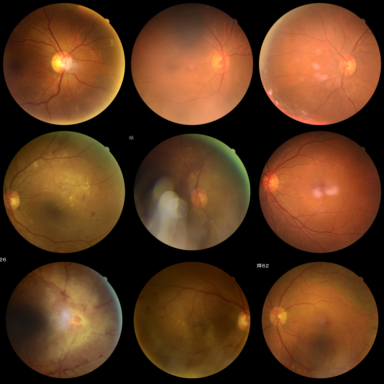

In [10]:
train_dataset.montage(length=3)

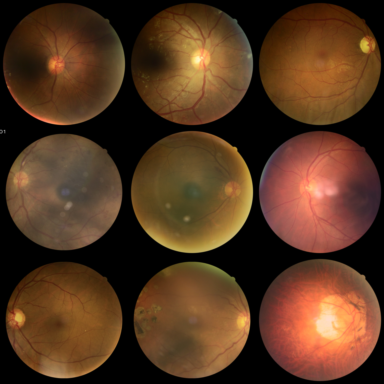

In [11]:
val_dataset.montage(length=3)

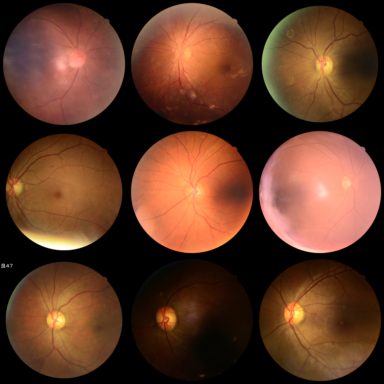

In [12]:
test_dataset.montage(length=3)

In [13]:
train_dataset[5]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 array([0]))

# Define network and optimizer

In [14]:
def create_model():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, n_classes) # Removed Sigmoid activation
    return model

In [15]:
model = create_model()
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 11188697


In [16]:
criterion = nn.CrossEntropyLoss() # Changed from nn.BCELoss()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, optimizer,  device="cuda"):
    """Train the model on the training set."""
    model.train()
    model.to(device)
    total_loss = 0.0

    for images, labels in tqdm(trainloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(1).long()) # Squeeze labels and cast to long for CrossEntropyLoss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(trainloader.dataset)
    return avg_loss

def test(model, testloader, device="cuda"): # Added device argument
    """Evaluate the model on the test set."""
    model.eval()
    model.to(device) # Use the passed device
    total_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze(1).long()) # Squeeze labels and cast to long for CrossEntropyLoss
            total_loss += loss.item() * images.size(0)

            # For calculating accuracy with CrossEntropyLoss
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu())
            y_true.extend(labels.cpu().int().squeeze(1)) # Squeeze labels

    y_pred = torch.stack(y_pred)
    y_true = torch.stack(y_true)
    acc = (y_pred == y_true).sum().item() / y_true.numel()
    avg_loss = total_loss / len(testloader.dataset)
    return avg_loss, acc


def run_centralised(trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""
    model = create_model()

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train(model, trainloader, optimizer)
        print(f"Train loss: {train_loss:.4f}")

    test_loss, test_acc = test(model, testloader)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

In [17]:
# Run the centralised training
run_centralised(train_loader, test_loader, epochs=3, lr=0.01)

Epoch 1/3


AssertionError: Torch not compiled with CUDA enabled

# Federated Learning

In [34]:
# Number of partitions
NUM_PARTITIONS = 10

# Number of elements per partition
part_len = len(train_dataset) // NUM_PARTITIONS

# Check for remainder
remainder = len(train_dataset) % NUM_PARTITIONS

# If there is a remainder, distribute the extra elements evenly
part_lengths = [part_len] * NUM_PARTITIONS

# If there is a remainder, add 1 extra element to the first few partitions
for i in range(remainder):
    part_lengths[i] += 1

# Split into subsets
fds = random_split(train_dataset, part_lengths)

# Check the number of elements in each subset
print(f"Number of elements in each partition dataset:")
for i, part_data in enumerate(fds):
    print(f"Partition {i}: {len(part_data)} samples")

Number of elements in each partition dataset:
Partition 0: 108 samples
Partition 1: 108 samples
Partition 2: 108 samples
Partition 3: 108 samples
Partition 4: 108 samples
Partition 5: 108 samples
Partition 6: 108 samples
Partition 7: 108 samples
Partition 8: 108 samples
Partition 9: 108 samples


In [35]:
# We could load a single partition like this
partition_0 = fds[0]
partition_0

In [36]:
partition_0[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 array([1]))

# Visualization of the partitioned datasets

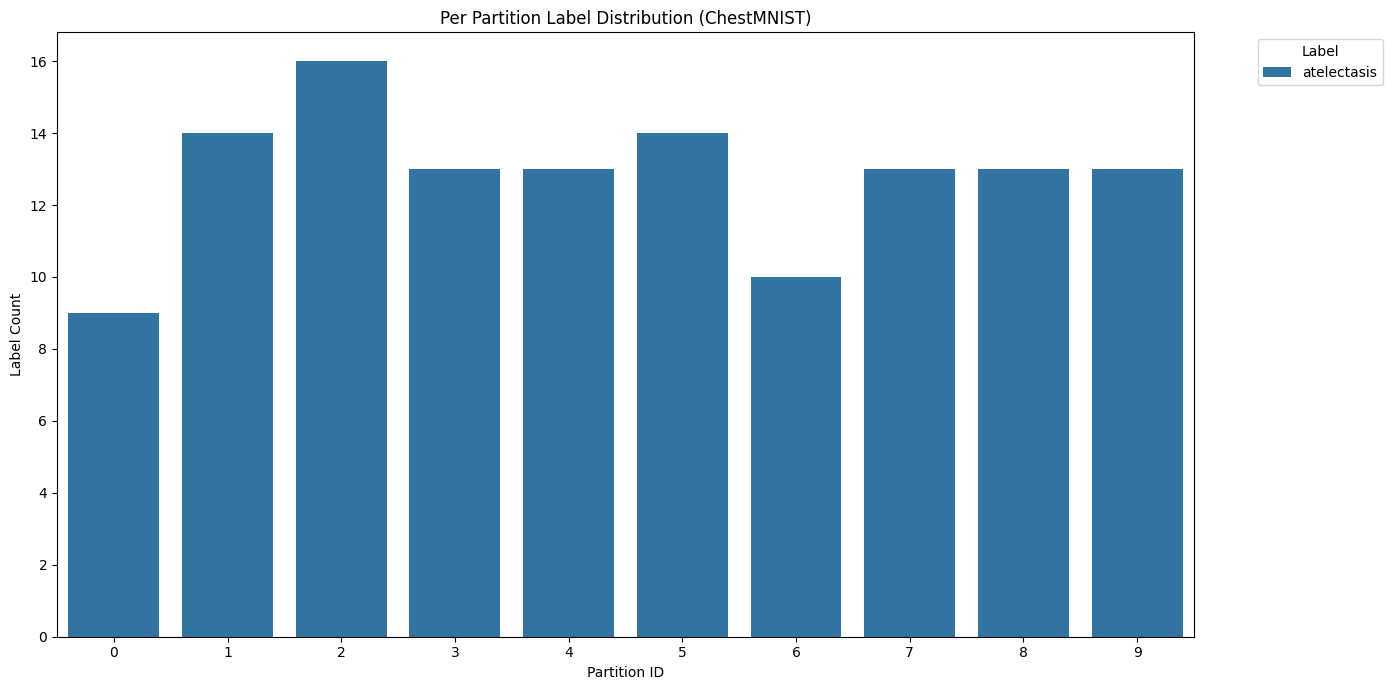

In [37]:
label_mapping = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass',
                 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema',
                 'emphysema', 'fibrosis', 'pleural', 'hernia']

label_data = []

for part_id, dataset in enumerate(fds):
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = torch.tensor(label)
        label = label.int()
        for class_id, value in enumerate(label):
            if value == 1:
                label_data.append({"part_id": part_id, "label": label_mapping[class_id]})

df_labels = pd.DataFrame(label_data)

plt.figure(figsize=(14, 7))
sns.countplot(data=df_labels, x="part_id", hue="label", palette="tab20")
plt.title("Per Partition Label Distribution (ChestMNIST)")
plt.xlabel("Partition ID")
plt.ylabel("Label Count")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

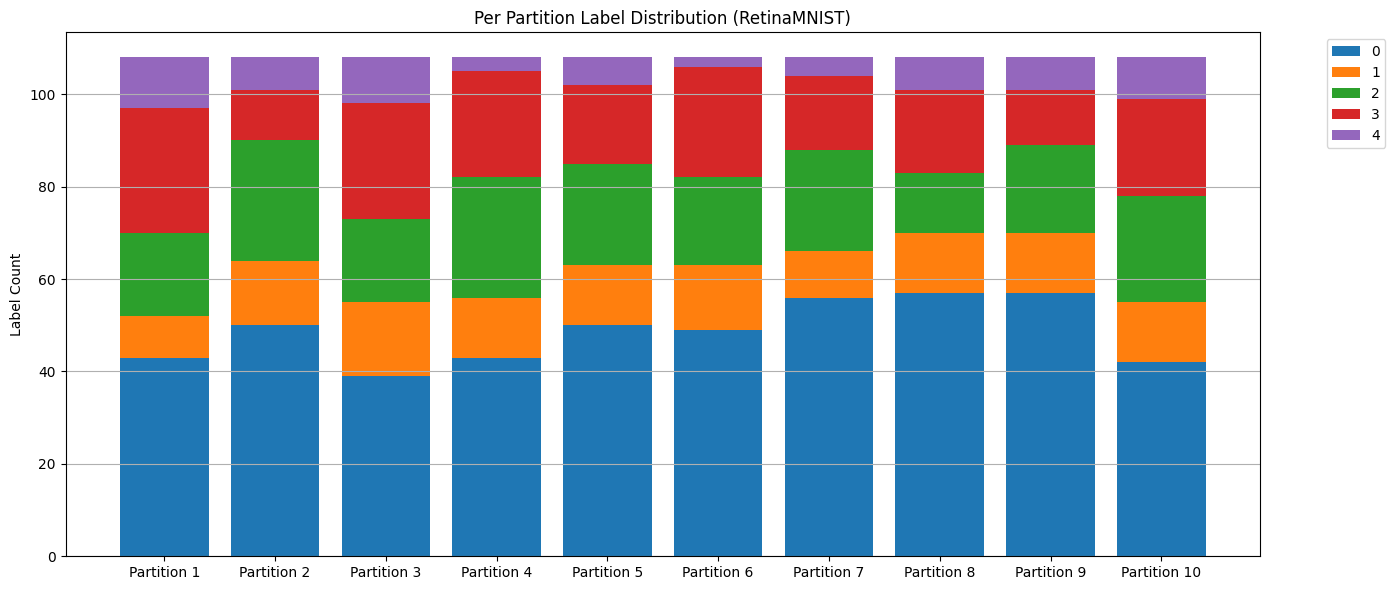

In [38]:
label_mapping = ['0', '1', '2', '3', '4']

label_counts_per_part = []

for part_data in fds:
    # Extract the single-value labels and count occurrences of each class
    labels = [item[1].item() for item in part_data]  # Extract single label value
    label_counts = [labels.count(i) for i in range(len(label_mapping))] # Count occurrences of each label
    label_counts_per_part.append(label_counts)

label_counts_per_client = np.array(label_counts_per_part)  # shape: (num_clients, num_labels)

# stacked bar chart
fig, ax = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(label_counts_per_client))

for i, label_name in enumerate(label_mapping):
    ax.bar(
        np.arange(len(label_counts_per_client)),
        label_counts_per_client[:, i],
        bottom=bottom,
        label=label_name
    )
    bottom += label_counts_per_client[:, i]

ax.set_xticks(np.arange(len(label_counts_per_client)))
ax.set_xticklabels([f'Partition {i+1}' for i in range(len(label_counts_per_client))])
ax.set_ylabel("Label Count")
ax.set_title("Per Partition Label Distribution (RetinaMNIST)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

# Defining a Flower ClientApp

In [39]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = train_loader
        self.valloader = val_loader
        self.model = create_model()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy = test(self.model, self.valloader, self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}


# Two auxhiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    # now replace the parameters
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

# The `client_fn` callback

In [40]:
from flwr.common import Context
from flwr.client import ClientApp
from torch.utils.data import random_split, DataLoader

def client_fn(context: Context):
    """Return a FlowerClient with its own train/validation dataloaders."""

    partition_id = int(context.node_config["partition-id"])

    # Retrieve the client's dataset
    client_data = fds[partition_id]

    # split on train/val (90%/10%)
    val_size = int(len(client_data) * 0.1)
    train_size = len(client_data) - val_size
    train_subset, val_subset = random_split(client_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    trainloader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    valloader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    return FlowerClient(trainloader=trainloader, valloader=valloader).to_client()


# Initialize the ClientApp
client_app = ClientApp(client_fn=client_fn)

# Defining a Flower `ServerApp`

In [41]:
from typing import List
from flwr.common import Metrics


# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# The `server_fn` callback

In [42]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 3


def server_fn(context: Context):

    # instantiate the model
    model = create_model()
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.5,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

# Launching the Simulation

In [43]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)
(pid=17258) 2025-06-23 20:56:21.849800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=17258) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=17258) E0000 00:00:1750712181.873375   17258 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=17258) E0000 00:00:1750712181.879636   17258 cuda_blas.cc:1418] Unable to register cuBLAS factory: